# 5. Interesting Tidbits

I'll post answers to some common questions, and some interesting peculiarities here. 


## 5.1 Interesting failure modes!

Let's look at what is happening when we use quad to integrate. 

It is doing a numerical integral using the original QUADPACK FORTRAN 77 library for numerical integration.  (You used to have a book called "Numerical Recipes" that you had to look up to code all these yourself, but now they come as handy functions someone else has coded up for you.) 

Hopefully you've learned methods of numerical integration before, such as the trapezoidal rule and Simpson's rule.  This is basically a variant of that, where you divide the integral up into subregions, calculate the approximate integral, and keep subdividing until the difference between one step and the next goes under some tolerance.  

QUADPACK info: https://en.wikipedia.org/wiki/QUADPACK 

Note you can force it to do different types of approximations for different circumstances, and depending on your problem some will suit better.  For example if you need to integrate to infinity you can choose an approximation scheme that is optimised to that case, which may be quite different that integrating over some low numbers. 

As with all approximations these sometimes fail, though.  An interesting example of a numerical failure is Runge's phenomenon, when higher-order polynomial fitting becomes unstable at the edges of an interval. https://en.wikipedia.org/wiki/Runge%27s_phenomenon 

Here's an example of a failure mode for our integral....

### 5.1.1 Setup for a standard model.
Code 1/(da/dt) for the standard model with a cosmological constant and matter.
$$ \frac{\dot{a}}{a} = H_0 \left[\Omega_M a^{-3}+\Omega_K a^{-2} + \Omega_\Lambda \right]^{1/2}. $$

In [1]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc
H0s = H0kmsmpc * 3.2408e-20 # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)
H0y = H0s * 3.154e7 * 1.e9 # H0 in inverse Giga years is H0 in inverse seconds * (3.154e7 seconds/year) * (1e9 years / Giga year)

# Write a function for the integrand, i.e. $1/\dot{a}$ (adot inverse), for a LambdaCDM model
# I'm going to keep the constant H_0 outside the integral and add it later.
# This takes as input a, Omega_M (om), and Omega_Lambda (ol) and outputs 1/adot
def adotinv(a,om,ol):
    ok = 1.0-om-ol
    adot=om/a + ok + ol*a**2 #'Your code here (Remember to keep H_0 separate i.e. just calculate adot/H_0.)'
    return 1.0/adot

# Start by making an array of scalefactors
astart = 0.0000
astop = 2.1
astep = 0.1 # Make this finer to make the plot smoother
a_arr = np.arange(astart,astop,astep)


### 5.1.2 Evaluation

Now let's integrate this function for a case that we know is a bouncing universe.

/var/folders/qq/l6wg7tcs043bq_kxppvnr5_c0000gp/T/ipykernel_27394/3317380947.py:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t_Gyr = np.array([integrate.quad(adotinv, 1.0, a_end, args=(om,ol))[0] for a_end in a_arr])/H0y


Text(0, 0.5, 'scalefactor')

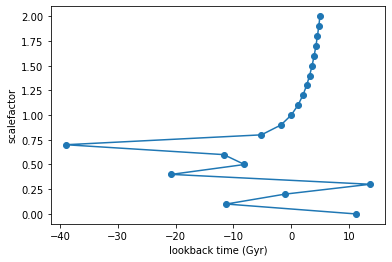

In [2]:
# Calculate for a universe that has an unstable integral! matter density 0.1 and cosmological constant 2.0
om = 0.10  
ol = 2.1

t_Gyr = np.array([integrate.quad(adotinv, 1.0, a_end, args=(om,ol))[0] for a_end in a_arr])/H0y

scatter=plt.scatter(t_Gyr,a_arr)
plt.plot(t_Gyr,a_arr)
plt.xlabel('lookback time (Gyr)')
plt.ylabel('scalefactor')

### 5.1.3 Uh oh, something doesn't look right!

And sure enough, the integral gave a warning showing that something probably went wrong with the integral.  This behaviour is not physical, it is a result of numerical error.  Let's look more closely at the integral to find the cause. 

[7.87460608e-01 5.51600245e-02 9.96609732e-03 3.53074392e-01
 8.68532370e-02 1.25327397e-01 9.96609737e-03 7.37211082e-02
 1.75140175e-13 1.41147716e-15 0.00000000e+00 9.25632183e-16
 1.59659502e-15 2.11233946e-15 2.52454470e-15 2.86336573e-15
 5.21339363e-14 7.10800355e-13 6.10927794e-12 3.74106821e-11
 1.76999794e-10]


/var/folders/qq/l6wg7tcs043bq_kxppvnr5_c0000gp/T/ipykernel_27394/3165905538.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t_lookback_Gyr[i],uncert[i] = integrate.quad(adotinv, 1.0, a_end, args=(om,ol))
/var/folders/qq/l6wg7tcs043bq_kxppvnr5_c0000gp/T/ipykernel_27394/3165905538.py:15: RuntimeWarning: divide by zero encountered in log10
  scatter=plt.scatter(t_lookback_Gyr,a_arr,c=np.log10(uncert))


Text(0, 0.5, 'scalefactor')

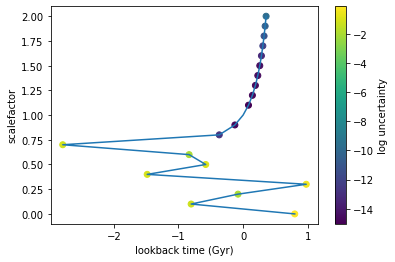

In [3]:
# Let's separate the one-line integral into it's parts.  

# integrate.quad actually returns two values... but we just chose the first of those by putting a [0] at the end. 

# Instead let's save both values.  The first is the answer to the integral, the second is the approximation of the uncertainty in the answer. 
t_lookback_Gyr = np.zeros(len(a_arr))
uncert = np.zeros(len(a_arr))
for i,a_end in enumerate(a_arr):
    t_lookback_Gyr[i],uncert[i] = integrate.quad(adotinv, 1.0, a_end, args=(om,ol))

# Now print the array of uncertainties.  You can see that most of them are down below 10**(-10), but a few are up at the 0.1 level. 
print(uncert)

# So lets redo that scatter plot, but colour code by log uncertainty (the power at the end of the number).
scatter=plt.scatter(t_lookback_Gyr,a_arr,c=np.log10(uncert))
plt.plot(t_lookback_Gyr,a_arr)
cbar = plt.colorbar(scatter)
cbar.set_label('log uncertainty')
plt.xlabel('lookback time (Gyr)')
plt.ylabel('scalefactor')


You can see that the part where the integral looks like it goes crazy, is indeed the part where the code is telling you the integral had a large uncertainty (and therefore probably failed).  

### 5.1.4 Solution, select only those points where the integral worked. 

/var/folders/qq/l6wg7tcs043bq_kxppvnr5_c0000gp/T/ipykernel_27394/2668970717.py:2: RuntimeWarning: divide by zero encountered in log
  i_good = np.log(uncert) < -10   # Select the indices corresponding to low uncertainty.
/var/folders/qq/l6wg7tcs043bq_kxppvnr5_c0000gp/T/ipykernel_27394/2668970717.py:9: RuntimeWarning: divide by zero encountered in log10
  scatter=plt.scatter(t_good,a_good,c=np.log10(uncert[i_good]))


[1.75140175e-13 1.41147716e-15 0.00000000e+00 9.25632183e-16
 1.59659502e-15 2.11233946e-15 2.52454470e-15 2.86336573e-15
 5.21339363e-14 7.10800355e-13 6.10927794e-12 3.74106821e-11
 1.76999794e-10]


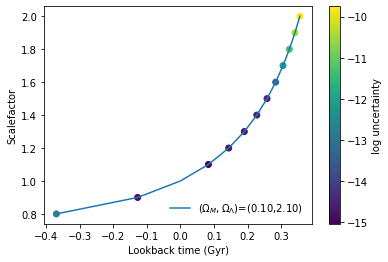

In [4]:
# Choose only those integrals that converged
i_good = np.log(uncert) < -10   # Select the indices corresponding to low uncertainty.
t_good = t_lookback_Gyr[i_good] # Select the times corresponding to those low-uncertainty points.
a_good = a_arr[i_good]          # Select the scalefactors corresponding to those low-uncertainty points. 

print (uncert[i_good])
# Plot this new model (note I've added a label that can be used in the legend)
#plt.plot(t_lookback_Gyr, a_arr,'.',label='$(\Omega_M,\Omega_\Lambda)$=(%.2f,%.2f)'%(om,ol))
scatter=plt.scatter(t_good,a_good,c=np.log10(uncert[i_good]))
plt.plot(t_good,a_good,label='$(\Omega_M,\Omega_\Lambda)$=(%.2f,%.2f)'%(om,ol)) 
cbar = plt.colorbar(scatter)
cbar.set_label('log uncertainty')
plt.xlabel('Lookback time (Gyr)')
plt.ylabel('Scalefactor')
plt.legend(loc='lower right',frameon=False)
plt.show()

You can see that the scale on the log uncertainty colour bar is very different to the one above, the worst is now 10^(-10) instead of 10^(0)!

By the way, equation 21 in the notes lets you figure out which universes will bounce.

## 5.2 Interpolation

You'll find that with thousands of supernovae your code runs really slowly.  The slowest step is the integration to get the luminosity distance.  You'll also notice that there are many supernovae at almost the same redshift.  Since the luminosity distance vs redshift curve is pretty smooth, you don't actually have to do the integral every time, you can do the integral a handful of times and interpolate between the points.  

Here's some code that shows you how to do that:

In [12]:
### Just make an example cosmology and an example set of observed redshifts (you don't need this line in your code)
def ezinv(z,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    ez = np.sqrt((1+z)**3)  # EXAMPLE FUNCTION -- NOT THE TRUE E(z)!!
    return 1./ez
om,ol,w0,wa,orr=0.3,0.7,-1.0,0.0,0.0  # An example cosmology
zs = [0.123,0.345,0.567,0.789,0.901]  # An example set of redshifts

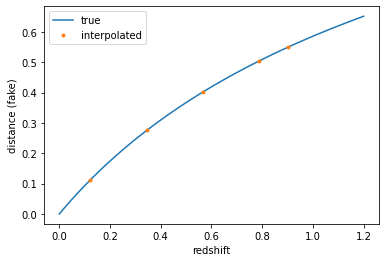

In [20]:
# Set up an array of redshifts, in this example we're choosing 50 between 0.0001<z<1.2.  
# Make sure this covers the entire range of your redshift data. 
z_array = np.linspace(0.0001,1.2,50)

# Calculate the comoving distance to each of those redshifts
xx_array = np.array([integrate.quad(ezinv, 0, z, args=(om, ol, w0, wa, orr))[0] for z in z_array])

# Interpolate from the 50 redshifts above to the redshifts "zs" in your data.
xx = np.interp(zs, z_array, xx_array)

plt.plot(z_array,xx_array,label='true')
plt.plot(zs,xx,'.',label='interpolated')
plt.xlabel('redshift')
plt.ylabel('distance (fake)')
plt.legend()
plt.show()

## Analytic Marginalisation

In the code supplied we marginalise over the absolute magnitude of supernovae by doing a loop over a wide range of possible Mscr values.  Loops in code are slow, and in this case the best Mscr to use can be derived analytically.  The outline of the derivation can be found in the appendix of Goliath et al. 2001: https://arxiv.org/abs/astro-ph/0104009

Here's some code that implements it.  (It won't run here, but you can cut and paste it in.)

In [ ]:
# The following is if you're using diagonal errors (an error bar on each supernova individually)
def chi2_mscranalytic(delta,sigma):
    # delta is the array of differences between mu_model and mu_observed for each supernova
    chit2 = np.sum(delta**2/sigma**2)
    B = np.sum(delta/sigma**2)
    C = np.sum(1/sigma**2)
    chi2 = chit2 - (B**2 / C) + np.log(C / (2* np.pi))
    chi2=np.nan_to_num(chi2,nan=9999.) # catches any not-a-number values
    return chi2

# The following is if you're using a covariance matrix (taking into account correlations between supernovae)
def chi2_mscranalytic_covariance(delta,cov2d):
    # delta is the array of differences between mu_model and mu_observed for each supernova
    deltaT = np.transpose(delta)
    chit2 = np.sum(delta @ cov2d @ deltaT)
    B = np.sum(delta @ cov2d)
    C = np.sum(cov2d)
    chi2 = chit2 - (B**2 / C) + np.log(C / (2* np.pi))
    chi2=np.nan_to_num(chi2,nan=9999.) # catches any not-a-number values
    return chi2